## Geolocation Fraud Detection Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
import joblib
import shap
import os
from imblearn.metrics import geometric_mean_score

In [74]:
df = pd.read_csv('/content/drive/My Drive/FYP_model_assets/geolocation_fraud_dataset.csv')

In [75]:
df

,transaction_id,timestamp,amount,currency,transaction_type,country,city,latitude,longitude,ip_address,...,transactions_last_7d,time_since_last_login,login_attempts_last_24h,is_new_device,vpn_usage,proxy_usage,ip_risk_score,ASN,ISP,is_fraud
0,17267,2025-01-28 00:34:00.291206,261.11,JPY,PURCHASE,TR,Hallchester,NaN,131.475327,104.252.129.91,...,7,79.5,3,0,1,1,11,72572,"Garcia, Mueller and Collins",0
1,90569,2025-02-08 23:20:06.875266,21.57,EUR,WITHDRAWAL,US,Port Lindaville,71.108646,67.911829,141.155.161.25,...,5,45.5,1,0,0,0,36,31015,"Stewart, Banks and Harvey",0
2,20959,2025-01-01 10:28:07.661918,80.73,GBP,PURCHASE,PS,Shawnborough,NaN,41.949825,20.229.90.101,...,12,45.7,5,0,0,0,29,71203,Thomas-Rodriguez,0
3,7776,2025-01-02 10:24:46.009232,79.32,EUR,TRANSFER,MH,East Jeffreyton,NaN,9.634126,138.187.225.190,...,6,83.2,5,0,0,0,34,88766,Powell-Brooks,0
4,123935,2025-02-26 08:38:37.398943,40.37,JPY,TRANSFER,BY,Kaitlynbury,47.217326,NaN,154.148.213.129,...,7,32.6,2,0,0,0,30,90183,Reed-Wilson,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,143487,2025-03-05 13:47:49.978166,13.58,EUR,TRANSFER,OM,Deborahland,-48.743021,NaN,167.186.84.217,...,6,165.6,5,0,0,0,66,33814,Cook PLC,0
199996,80492,2025-03-04 15:09:54.342152,10.71,JPY,TRANSFER,CG,New Kevin,-85.094167,-175.531951,208.74.235.19,...,12,15.1,3,0,0,0,45,99696,Williams-Vega,0
199997,194191,2025-02-20 04:54:46.799870,47.58,EUR,PURCHASE,KI,Lake Kevinberg,-10.462643,63.912476,121.188.232.206,...,8,66.9,0,0,0,0,51,19939,Hughes-Winters,0
199998,71976,2025-02-28 03:02:05.570887,228.48,JPY,TRANSFER,BJ,Williamberg,-13.197699,NaN,75.112.85.144,...,4,4.4,4,0,0,0,46,19483,Austin Ltd,0


In [76]:
df.isnull().sum()

,0
transaction_id,0
timestamp,0
amount,0
currency,0
transaction_type,0
country,990
city,0
latitude,39969
longitude,39813
ip_address,0


#### Data Preprocessing

In [77]:
drop_cols = ['transaction_id', 'timestamp', 'device_id', 'ip_address', 'user_id', 'user_agent', 'city']
df.drop(columns=drop_cols, inplace=True)

In [78]:
df.head(5)

,amount,currency,transaction_type,country,latitude,longitude,timezone,device_type,operating_system,app_version,...,transactions_last_7d,time_since_last_login,login_attempts_last_24h,is_new_device,vpn_usage,proxy_usage,ip_risk_score,ASN,ISP,is_fraud
0,261.11,JPY,PURCHASE,TR,NaN,131.475327,Europe/Luxembourg,Desktop,iOS,6.8.3,...,7,79.5,3,0,1,1,11,72572,"Garcia, Mueller and Collins",0
1,21.57,EUR,WITHDRAWAL,US,71.108646,67.911829,Africa/Khartoum,Mobile,iOS,5.0.5,...,5,45.5,1,0,0,0,36,31015,"Stewart, Banks and Harvey",0
2,80.73,GBP,PURCHASE,PS,NaN,41.949825,Asia/Taipei,Mobile,Windows,5.9.4,...,12,45.7,5,0,0,0,29,71203,Thomas-Rodriguez,0
3,79.32,EUR,TRANSFER,MH,NaN,9.634126,Asia/Aden,Desktop,Android,2.1.8,...,6,83.2,5,0,0,0,34,88766,Powell-Brooks,0
4,40.37,JPY,TRANSFER,BY,47.217326,NaN,Europe/Helsinki,Mobile,Windows,4.0.4,...,7,32.6,2,0,0,0,30,90183,Reed-Wilson,0


These fields are either:
- Not available during real-time inference (e.g., transaction_id)
- Too high-cardinality for tree models (ip_address, user_agent)
- Not adding predictive value or cause input bloat in Triton

#### Label and Feature Separation

In [80]:
target_col = "is_fraud"
binary_cols = ['vpn_usage', 'proxy_usage', 'is_new_device']
categorical_cols = [
    'currency', 'transaction_type', 'country', 'device_type',
    'operating_system', 'app_version', 'timezone', 'ISP'
]
numeric_cols = [
    'amount', 'avg_spend_30d', 'transactions_last_7d',
    'time_since_last_login', 'login_attempts_last_24h',
    'ip_risk_score', 'latitude', 'longitude'
]

#### Imputation and Encoding

In [81]:
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

df['country'] = df['country'].fillna("missing")

- Median imputation is robust to outliers and common for fraud datasets (due to skewed features like amount).
- Keeps the numerical shape consistent for Triton inference.

In [82]:
df[binary_cols] = df[binary_cols].astype(int)

In [83]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[categorical_cols] = ordinal_encoder.fit_transform(df[categorical_cols])

In [84]:
# print type of each column for df
print(df.dtypes)

amount                     float64
currency                   float64
transaction_type           float64
country                    float64
latitude                   float64
longitude                  float64
timezone                   float64
device_type                float64
operating_system           float64
app_version                float64
avg_spend_30d              float64
transactions_last_7d       float64
time_since_last_login      float64
login_attempts_last_24h    float64
is_new_device                int64
vpn_usage                    int64
proxy_usage                  int64
ip_risk_score              float64
ASN                          int64
ISP                        float64
is_fraud                     int64
dtype: object


1. Label/Ordinal Encoding is better for XGBoost, which handles category splits natively.
2. One-hot encoding causes dimensionality explosion, unnecessary with tree models.
3. Triton expects fixed input shape, so we avoid sparse/dynamic one-hot formats.

In [85]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [86]:
del(df)

#### Train Test Split

In [87]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

#### Model Training

In [88]:
from xgboost import XGBClassifier

scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.05,
    n_estimators=500,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)


[0]	validation_0-auc:0.76367
[1]	validation_0-auc:0.86896
[2]	validation_0-auc:0.90055
[3]	validation_0-auc:0.90532


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:32:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-auc:0.90216
[5]	validation_0-auc:0.90413
[6]	validation_0-auc:0.90524
[7]	validation_0-auc:0.90470
[8]	validation_0-auc:0.90530
[9]	validation_0-auc:0.90573
[10]	validation_0-auc:0.90654
[11]	validation_0-auc:0.90670
[12]	validation_0-auc:0.90649
[13]	validation_0-auc:0.90689
[14]	validation_0-auc:0.90632
[15]	validation_0-auc:0.90709
[16]	validation_0-auc:0.90734
[17]	validation_0-auc:0.90759
[18]	validation_0-auc:0.90866
[19]	validation_0-auc:0.90868
[20]	validation_0-auc:0.90869
[21]	validation_0-auc:0.90899
[22]	validation_0-auc:0.90898
[23]	validation_0-auc:0.90872
[24]	validation_0-auc:0.90835
[25]	validation_0-auc:0.90846
[26]	validation_0-auc:0.90866
[27]	validation_0-auc:0.90866
[28]	validation_0-auc:0.90886
[29]	validation_0-auc:0.90877
[30]	validation_0-auc:0.90841
[31]	validation_0-auc:0.90853
[32]	validation_0-auc:0.90856
[33]	validation_0-auc:0.90857
[34]	validation_0-auc:0.90884
[35]	validation_0-auc:0.90898
[36]	validation_0-auc:0.90921
[37]	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Classification Report:
              precision    recall  f1-score   support

           0     0.9877    0.9203    0.9528     38500
           1     0.2565    0.7060    0.3763      1500

    accuracy                         0.9123     40000
   macro avg     0.6221    0.8131    0.6646     40000
weighted avg     0.9603    0.9123    0.9312     40000



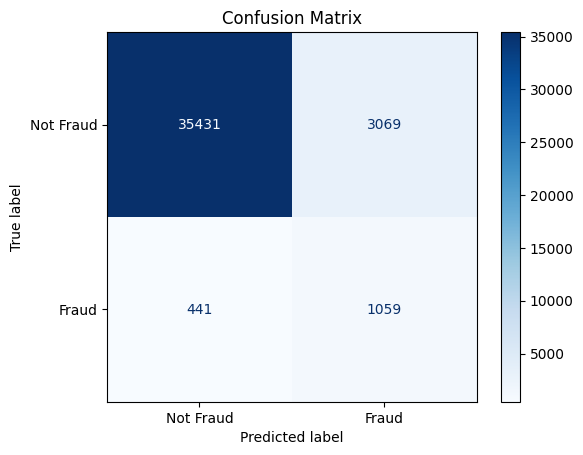

Geometric Mean Score: 0.8061


In [89]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)

print("\nClassification Report:")
print(classification_report(y_val, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Not Fraud", "Fraud"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

gmean = geometric_mean_score(y_val, y_pred)
print(f"Geometric Mean Score: {gmean:.4f}")


Feature Importance

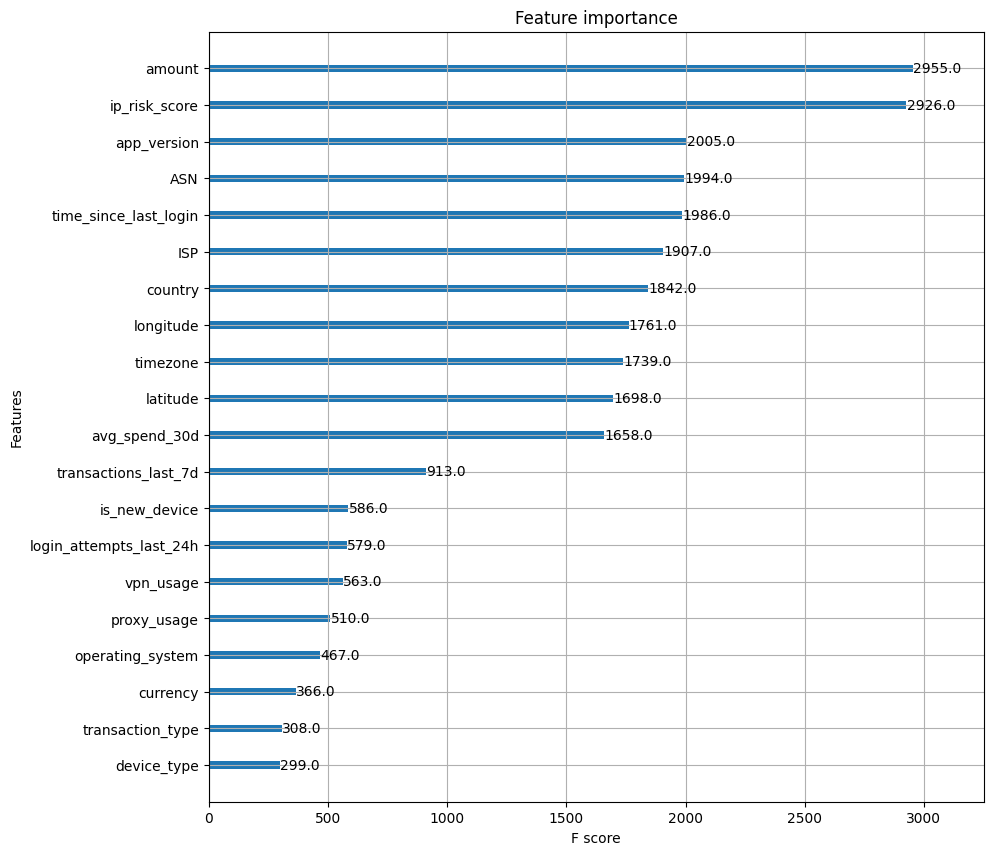

In [95]:
# plot feature importance from xgboost model
import matplotlib.pyplot as plt
import xgboost

fig, ax = plt.subplots(figsize=(10, 10))
xgboost.plot_importance(model, importance_type="weight", ax=ax)
plt.show()

In [97]:
import joblib

model.save_model("/content/drive/MyDrive/FYP_model_assets/xgb_geolocation_fraud_model.bst")
joblib.dump(ordinal_encoder, "/content/drive/MyDrive/FYP_model_assets/geoloc_encoder.pkl")
joblib.dump(num_imputer, "/content/drive/MyDrive/FYP_model_assets/geoloc_imputer.pkl")

# Save feature names to ensure Triton/microservice aligns
import json
with open("geolocation_fraud_feature_order.json", "w") as f:
    json.dump(list(X.columns), f)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:01:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
